In [202]:
%load_ext pretty_jupyter
import plotly
plotly.offline.init_notebook_mode()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
mesh = pd.read_pickle('raw_data/term_meshes.pkl')
why_stop = pd.read_csv('raw_data/why_stop.csv')
ct= pd.read_csv('raw_data/ct_10_07.csv')
# set theming to "seaborn" (instead of matplotlib) and set background to white so it works with both normal and darkmode
plt.plot([0, 1], [0, 1])
plt.close()
sns.set(rc={'figure.facecolor':'white'})
sns.set_style()


blue_color = sns.color_palette()[0]

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


In [203]:
%%jinja markdown

# Introduction
idk stuff etc column added after 2017 etc maybe a df with description of the terms


# Introduction
idk stuff etc column added after 2017 etc maybe a df with description of the terms

In [204]:
why_stop

nct_id                                           raw_text  \
0      NCT00000105                         Replaced by another study.   
1      NCT00000270    Study never opened; never enrolled participants   
2      NCT00000270    Study never opened; never enrolled participants   
3      NCT00000305                 Original P.I. left the institution   
4      NCT00000309      Unable to recruit adequate number of subjects   
...            ...                                                ...   
42916  NCT06355843  The 68Ge/68Ga generator is currently at the en...   
42917  NCT06362031                           Strategic considerations   
42918  NCT06371716  resectable pancreatic adenocarcinoma and neuro...   
42919  NCT06374680  This is because the same research has already ...   
42920  NCT06377722  The achieved number of samples has been smalle...   

                         category        class  num_reasons  
0               study_competition  stop_reason            1  
1                   never_started  stop_reason            2  
2              enrollment_related  stop_reason            2  
3                      pi_related  stop_reason            1  
4              enrollment_related  stop_reason            1  
...                           ...          ...          ...  
42916                      others  stop_reason            1  
42917  business_or_sponsor_reason  stop_reason            1  
42918          enrollment_related  stop_reason            1  
42919                      others  stop_reason            1  
42920          enrollment_related  stop_reason            1  

[42921 rows x 5 columns]

In [205]:
why_stop["nct_id"].nunique()



38401

In [206]:
# for each columns that end with Date, create a new column {x}_year and only keep the 4 first digits and convert to int
columns_to_convert = ['startDate']


for col in columns_to_convert:
    # Convert the column to datetime
    ct[col] = pd.to_datetime(ct[col])
    # Create a new column for the year
    ct[col] = ct[col].dt.year
  
why_stop = why_stop.merge(ct[['nct_id','startDate','overallStatus']], on='nct_id', how='left')

In [207]:

mesh['term'] = mesh['term'].replace('Urinary Tract, Sexual Organs, and Pregnancy Conditions', 'Uro-genitcal & pregnancy')
## subset with only major ancestor mesh

"""include_categories_mesh = ["Rare Diseases","Neoplasms","Heart and Blood Diseases","Nervous System Diseases","Behaviors and Mental Disorders",
                           "Uro-genitcal & pregnancy","Infections"]"""
                           
include_categories_mesh = ["Rare Diseases","Neoplasms","Nervous System Diseases","Infections",
                           "Respiratory Tract (Lung and Bronchial) Diseases","Immune System Diseases",
                           "Anti-Inflammatory Agents","Coronaviridae Infections"]
xx=mesh[(mesh['tree_level'] == 'browseBranches')|((mesh['tree_level'] == 'ancestors') & (mesh['term'] =='Coronaviridae Infections'))]
mesh_main_ancestor = xx[xx['term'].isin(include_categories_mesh)]

In [208]:
covid_trial =mesh[mesh['term'] == 'Coronaviridae Infections'][['nct_id','term']]
covid_trial.to_pickle('clean_data/covid_trial.pkl')

In [209]:
import numpy as np
# https://cyntegrity.com/7-reasons-clinical-trials-fail/ 

# copy the df first to avoid error from trying to modify the og df with subset of itself
why_stop = why_stop.copy()

why_stop['category'] = why_stop['category'].replace("enrollment_related",'enrollment_accrual_related')
why_stop['category'] = why_stop['category'].replace("slow_accrual",'enrollment_accrual_related')

why_stop["failure_type"] = np.where(why_stop['category'].isin(['efficacy',
                                                               'safety_ethics_aes','completed_early_or_truncated_completion']), 
                                    "clinical_failure", 
                                    "project_failure")

why_stop["failure_type"] = np.where(why_stop['category'].isin(['others','unclassified','pi_related','trial_no_longer_needed','covid-19_and_similar_epidemic_related','study_competition']), 
                                    "others_failure", 
                                    why_stop['failure_type'])



In [210]:
why_stop

nct_id                                           raw_text  \
0      NCT00000105                         Replaced by another study.   
1      NCT00000270    Study never opened; never enrolled participants   
2      NCT00000270    Study never opened; never enrolled participants   
3      NCT00000305                 Original P.I. left the institution   
4      NCT00000309      Unable to recruit adequate number of subjects   
...            ...                                                ...   
42916  NCT06355843  The 68Ge/68Ga generator is currently at the en...   
42917  NCT06362031                           Strategic considerations   
42918  NCT06371716  resectable pancreatic adenocarcinoma and neuro...   
42919  NCT06374680  This is because the same research has already ...   
42920  NCT06377722  The achieved number of samples has been smalle...   

                         category        class  num_reasons  startDate  \
0               study_competition  stop_reason            1       2002   
1                   never_started  stop_reason            2       1995   
2      enrollment_accrual_related  stop_reason            2       1995   
3                      pi_related  stop_reason            1       1900   
4      enrollment_accrual_related  stop_reason            1       1994   
...                           ...          ...          ...        ...   
42916                      others  stop_reason            1       2022   
42917  business_or_sponsor_reason  stop_reason            1       2023   
42918  enrollment_accrual_related  stop_reason            1       2019   
42919                      others  stop_reason            1       2017   
42920  enrollment_accrual_related  stop_reason            1       2018   

      overallStatus     failure_type  
0        TERMINATED   others_failure  
1         WITHDRAWN  project_failure  
2         WITHDRAWN  project_failure  
3        TERMINATED   others_failure  
4        TERMINATED  project_failure  
...             ...              ...  
42916     SUSPENDED   others_failure  
42917     WITHDRAWN  project_failure  
42918    TERMINATED  project_failure  
42919     WITHDRAWN   others_failure  
42920    TERMINATED  project_failure  

[42921 rows x 8 columns]

In [211]:
%%capture
"""# Repartition des diff cat d'arret 
# Count the frequency of each category
category_counts = why_stop['category'].value_counts()

total_unique_nct_id = why_stop['nct_id'].nunique()

category_percentage = (category_counts / total_unique_nct_id) * 100

# Convert the series to a DataFrame
category_percentage_df = category_percentage.reset_index()
category_percentage_df.columns = ['category', 'percentage']


category_counts_df = category_counts.reset_index()
category_counts_df.columns = ['category', 'count']
category_percentage_df = category_percentage_df.merge(category_counts_df, on='category', how='left')


# Count the frequency of each failure_type
failure_type_counts = why_stop['failure_type'].value_counts()

# Calculate the percentage of each failure_type
failure_type_percentage = (failure_type_counts / total_unique_nct_id) * 100

# Convert the series to a DataFrame
failure_type_percentage_df = failure_type_percentage.reset_index()
failure_type_percentage_df.columns = ['category', 'percentage']

failure_type_counts_df = failure_type_counts.reset_index()
failure_type_counts_df.columns = ['category', 'count']
failure_type_percentage_df = failure_type_percentage_df.merge(failure_type_counts_df, on='category', how='left')




# Concatenate the two DataFrames
category_percentage_dfx = pd.concat([failure_type_percentage_df,category_percentage_df], ignore_index=True)

# Display the DataFrame
category_percentage_dfx

category_percentage_dfx["failure_type"] = np.where(category_percentage_dfx['category'].isin(['efficacy',
                                                               'safety_ethics_aes','completed_early_or_truncated_completion']), 
                                    "clinical_failure", 
                                    "project_failure")

category_percentage_dfx["failure_type"] = np.where(category_percentage_dfx['category'].isin(['others','added_by_error','pi_related','trial_no_longer_needed','covid-19_and_similar_epidemic_related','study_competition']), 
                                    "others_failure", 
                                    category_percentage_dfx['failure_type'])

# Create a color map for failure_type
color_map = {'clinical_failure': 'red', 'project_failure': 'orange', 'others_failure': 'green'}

# Create a horizontal bar chart for category using all rows but the first three
fig, axs = plt.subplots(figsize=(20, 10))

# Create bars one by one and add them to the legend
for i in range(3, len(category_percentage_dfx)):
    bars = axs.barh(category_percentage_dfx['category'].iloc[i], category_percentage_dfx['percentage'].iloc[i], 
                    color=color_map[category_percentage_dfx['failure_type'].iloc[i]], 
                    label=category_percentage_dfx['failure_type'].iloc[i])
    # Add the row count at the end of each bar
    width = bars[0].get_width()
    axs.text(width, 
             bars[0].get_y() + bars[0].get_height()/2, 
             f' {category_percentage_dfx["count"].iloc[i]}', 
             ha='left', 
             va='center')

# Remove duplicate labels in the legend
handles, labels = axs.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs.legend(by_label.values(), by_label.keys())

axs.set_title('Percentage of Each Category')
plt.show()"""


In [212]:

# Repartition des diff cat d'arret 
# Count the frequency of each category
category_counts = why_stop['category'].value_counts()

total_unique_nct_id = why_stop['nct_id'].nunique()

category_percentage = (category_counts / total_unique_nct_id) * 100

# Convert the series to a DataFrame
category_percentage_df = category_percentage.reset_index()
category_percentage_df.columns = ['category', 'percentage']


category_counts_df = category_counts.reset_index()
category_counts_df.columns = ['category', 'count']
category_percentage_df = category_percentage_df.merge(category_counts_df, on='category', how='left')
category_percentage_df

category  percentage  count
0                   enrollment_accrual_related   37.124033  14256
1                   business_or_sponsor_reason   12.148121   4665
2                              funding_related   10.221088   3925
3                                       others    6.166506   2368
4        covid-19_and_similar_epidemic_related    6.072759   2332
5                                    logistics    6.028489   2315
6                                   pi_related    5.398297   2073
7                                     efficacy    5.314966   2041
8                                never_started    4.950392   1901
9    inadequate_study_design_or_study_redesign    4.145725   1592
10  negligence_or_recommandation_of_legalities    3.432202   1318
11                       organizational_issues    3.262936   1253
12                           safety_ethics_aes    3.130127   1202
13                      trial_no_longer_needed    1.710893    657
14     completed_early_or_truncated_completion    1.276008    490
15                           study_competition    0.911435    350
16                              added_by_error    0.447905    172

In [213]:

# Count the frequency of each failure_type
why_stop1 = why_stop.copy()

why_stop1.loc[why_stop1['category'] == 'enrollment_accrual_related', 'failure_type'] = 'enrollment_related'

why_stop1.loc[why_stop1['category'] == 'covid-19_and_similar_epidemic_related', 'failure_type'] = 'covid-19_restrictions'

failure_type_counts = why_stop1['failure_type'].value_counts()

# Calculate the percentage of each failure_type
failure_type_percentage = (failure_type_counts / total_unique_nct_id) * 100

# Convert the series to a DataFrame
failure_type_percentage_df = failure_type_percentage.reset_index()
failure_type_percentage_df.columns = ['category', 'percentage']

failure_type_counts_df = failure_type_counts.reset_index()
failure_type_counts_df.columns = ['category', 'count']
failure_type_percentage_df = failure_type_percentage_df.merge(failure_type_counts_df, on='category', how='left')

failure_type_percentage_df

category  percentage  count
0        project_failure   44.665504  17152
1     enrollment_related   37.124033  14256
2         others_failure   14.187131   5448
3       clinical_failure    9.721101   3733
4  covid-19_restrictions    6.072759   2332

In [214]:
%%jinja markdown

# Overview of the distribution of the reasons for early termination of clinical trials
[//]: <> (-.- tabset tabset-pills)


# Overview of the distribution of the reasons for early termination of clinical trials
<span class='pj-token' style='display: none;'>tabset|O_O|tabset-pills</span>

In [215]:
%%jinja markdown

## Main Terminations Categories


## Main Terminations Categories

In [216]:
category_percentage_df


category_percentage_df["failure_type"] = np.where(category_percentage_df['category'].isin(['efficacy',
                                                               'safety_ethics_aes','completed_early_or_truncated_completion']), 
                                    "clinical_failure", 
                                    "project_failure")

category_percentage_df["failure_type"] = np.where(category_percentage_df['category'].isin(['others','added_by_error','pi_related','trial_no_longer_needed','covid-19_and_similar_epidemic_related','study_competition']), 
                                    "others_failure", 
                                    category_percentage_df['failure_type'])


In [217]:
"""
category_percentage_dfx=category_percentage_dfx[3:]

failure_type_percentage_df.loc[failure_type_percentage_df['category'] == 'project_failure', 'percentage'] = 44.178686
failure_type_percentage_df.loc[failure_type_percentage_df['category'] == 'project_failure', 'count'] = 13539
category_percentage_dfx.sort_values(by='failure_type', ascending=False, inplace=True)
"""

"\ncategory_percentage_dfx=category_percentage_dfx[3:]\n\nfailure_type_percentage_df.loc[failure_type_percentage_df['category'] == 'project_failure', 'percentage'] = 44.178686\nfailure_type_percentage_df.loc[failure_type_percentage_df['category'] == 'project_failure', 'count'] = 13539\ncategory_percentage_dfx.sort_values(by='failure_type', ascending=False, inplace=True)\n"

In [218]:
%%jmd
From a first simple glance we can confirm the main reason for early termination is accrual issues. We also note that the actual scientific failures are the minority of terminations reasons.

From a first simple glance we can confirm the main reason for early termination is accrual issues. We also note that the actual scientific failures are the minority of terminations reasons.

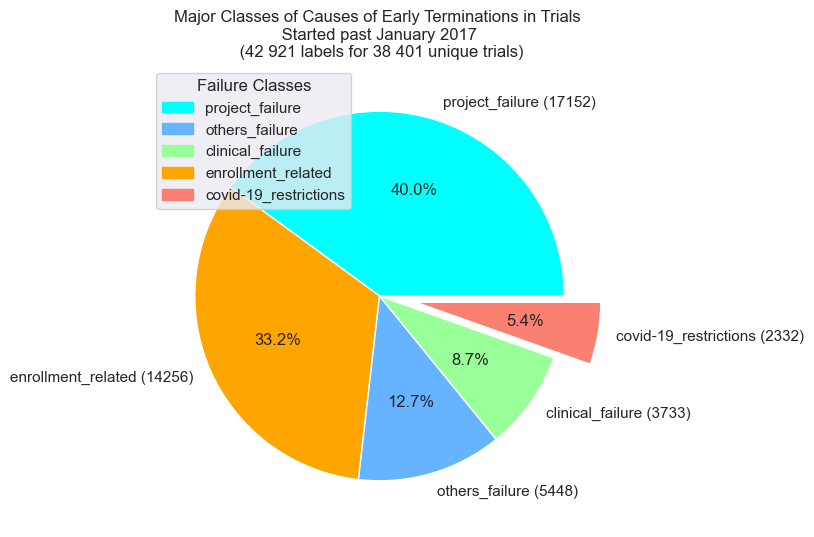

In [219]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define a color map for each failure type
color_map = {
    'project_failure': 'cyan',
    'others_failure': '#66b3ff',
    'clinical_failure': '#99ff99',
    'enrollment_related': 'orange',
    'covid-19_restrictions': 'salmon'
    # Add more mappings as needed
}



# Create labels for the pie chart
labels = [f'{category} ({count})' for category, count in zip(failure_type_percentage_df['category'], failure_type_percentage_df['count'])]

# Assign colors based on the failure type
colors = [color_map[failure_type] for failure_type in failure_type_percentage_df['category']]
# Define explode to separate one category (e.g., the second category)
explode = [0, 0, 0, 0,0.2]  # Only "explode" the second slice (i.e., '0.1' means 10% separation)
# Create the pie chart
fig, axs = plt.subplots(figsize=(6, 6))
axs.pie(failure_type_percentage_df['percentage'], labels=labels, autopct='%1.1f%%', colors=colors, explode=explode,startangle=0)
axs.set_title('Major Classes of Causes of Early Terminations in Trials \n Started past January 2017 \n (42 921 labels for 38 401 unique trials)')

# Create a legend using Patch objects
legend_patches = [Patch(color=color, label=failure_type) for failure_type, color in color_map.items()]
axs.legend(handles=legend_patches, title="Failure Classes", loc="upper left")

# Display the plot
plt.show()


In [220]:
%%jmd 
## NLP extracted sub-categories

## NLP extracted sub-categories

In [221]:
%%jmd
This let us dig further into others potential stop reasons. We can also filter out the trials added by error before training our statistic models

This let us dig further into others potential stop reasons. We can also filter out the trials added by error before training our statistic models

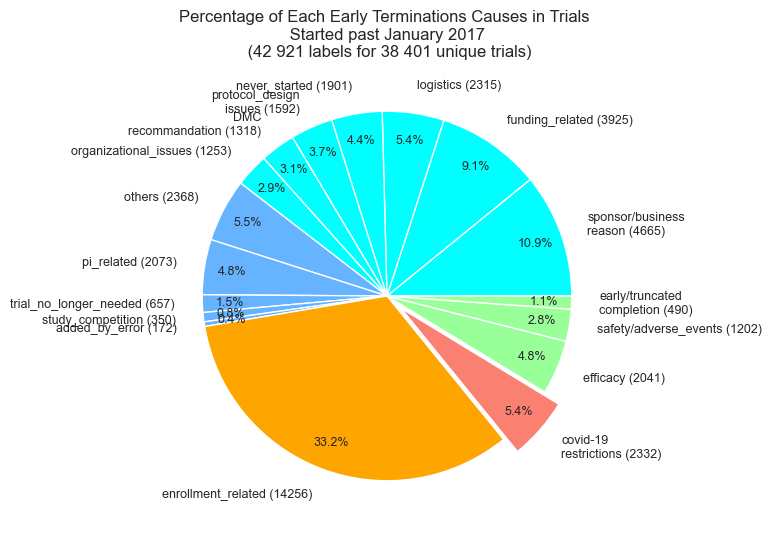

In [226]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define a color map for each failure type
color_map = {
    'project_failure': 'cyan',
    'others_failure': '#66b3ff',
    'clinical_failure': '#99ff99',
    'enrollment_related': 'orange',
    'covid-19_restrictions': 'salmon'
    # Add more mappings as needed
}


# Filter the DataFrame for the relevant categories
filtered_dfx = category_percentage_df
filtered_dfx.loc[filtered_dfx['category'] == 'enrollment_accrual_related', 'failure_type'] = 'enrollment_related'
filtered_dfx.loc[filtered_dfx['category'] == 'covid-19_and_similar_epidemic_related', 'failure_type'] = 'covid-19_restrictions'
filtered_dfx.loc[filtered_dfx['category'] == 'enrollment_accrual_related', 'category'] = 'enrollment_related'
filtered_dfx.loc[filtered_dfx['category'] == 'business_or_sponsor_reason', 'category'] = 'sponsor/business\nreason'
filtered_dfx.loc[filtered_dfx['category'] == 'negligence_or_recommandation_of_legalities', 'category'] = 'DMC\nrecommandation'
filtered_dfx.loc[filtered_dfx['category'] == 'covid-19_and_similar_epidemic_related', 'category'] = 'covid-19\nrestrictions'
filtered_dfx.loc[filtered_dfx['category'] == 'completed_early_or_truncated_completion', 'category'] = 'early/truncated\ncompletion'
filtered_dfx.loc[filtered_dfx['category'] == 'inadequate_study_design_or_study_redesign', 'category'] = 'protocol_design\nissues'
filtered_dfx.loc[filtered_dfx['category'] == 'safety_ethics_aes', 'category'] = 'safety/adverse_events'
filtered_dfx
filtered_dfx.sort_values(by=['failure_type', 'percentage'], ascending=[False, False], inplace=True)

# Create labels for the pie chart
labels = [f'{category} ({count})' for category, count in zip(filtered_dfx['category'], filtered_dfx['count'])]

# Assign colors based on the failure type
colors = [color_map[failure_type] for failure_type in filtered_dfx['failure_type']]
explodex = [0, 0, 0, 0,0,0, 0, 0, 0,0,0, 0, 0, 0.1,0,0,0]  # Only "explode" the second slice (i.e., '0.1' means 10% separation)
# Create the pie chart
fig, axs = plt.subplots(figsize=(6, 6))
axs.pie(
    filtered_dfx['percentage'], 
    labels=labels, 
    autopct='%1.1f%%', 
    colors=colors, 
    labeldistance=1.15,  # Distance of the labels from the center
    pctdistance=0.85,   # Distance of the percentage labels from the center
    textprops={'fontsize': 9},  # Font size for the text
    explode=explodex,
    startangle=0  # Start angle for the pie chart
)
axs.set_title('Percentage of Each Failure Type')
axs.set_title('Percentage of Each Early Terminations Causes in Trials \n Started past January 2017 \n (42 921 labels for 38 401 unique trials)')

# Create a legend using Patch objects
legend_patches = [Patch(color=color, label=failure_type) for failure_type, color in color_map.items()]

# Display the plot
plt.show()

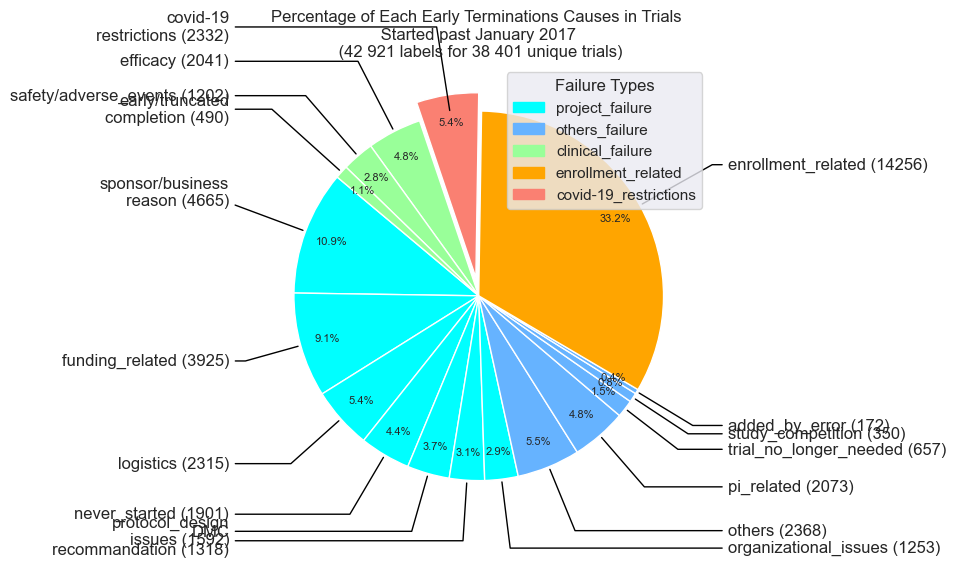

In [193]:
from matplotlib.patches import Patch
import numpy as np
import matplotlib.pyplot as plt

# Assuming filtered_dfx and color_map are already defined

labels = [f'{category} ({count})' for category, count in zip(filtered_dfx['category'], filtered_dfx['count'])]

# Assign colors based on the failure type
colors = [color_map[failure_type] for failure_type in filtered_dfx['failure_type']]
explodex = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0]  # Only "explode" the second slice (i.e., '0.1' means 10% separation)

# Create the pie chart
fig, axs = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = axs.pie(
    filtered_dfx['percentage'], 
    labels=labels, 
    autopct='%1.1f%%', 
    colors=colors, 
    labeldistance=1.1,  # Distance of the labels from the center
    pctdistance=0.85,   # Distance of the percentage labels from the center
    textprops={'fontsize': 8},  # Font size for the text
    explode=explodex,
    startangle=140  # Start angle for the pie chart
)

# Add lines from labels to pie slices
for i, (wedge, text) in enumerate(zip(wedges, texts)):
    angle = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
    x = wedge.r * np.cos(np.deg2rad(angle))
    y = wedge.r * np.sin(np.deg2rad(angle))
    horizontalalignment = {-1: 'right', 1: 'left'}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(angle)
    
    # Adjust xytext coordinates to reduce line length for labels near y=0
    if abs(y) < 0.1:
        xytext = (1.2 * np.sign(x), 1.2 * y)
    else:
        xytext = (1.35 * np.sign(x), 1.4 * y)
    
    axs.annotate(
        text.get_text(), xy=(x, y), xytext=xytext,
        horizontalalignment=horizontalalignment, 
        arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle, color='black')
    )
    text.set_text('')  # Remove the original text

axs.set_title('Percentage of Each Early Terminations Causes in Trials \n Started past January 2017 \n (42 921 labels for 38 401 unique trials)')

# Create a legend using Patch objects
legend_patches = [Patch(color=color, label=failure_type) for failure_type, color in color_map.items()]
axs.legend(handles=legend_patches, title="Failure Types", loc="upper right")

# Display the plot
plt.show()

In [95]:
%%jinja markdown
# Distribution of the failure types over the years
[//]: <> (-.- tabset tabset-pills)

# Distribution of the failure types over the years
<span class='pj-token' style='display: none;'>tabset|O_O|tabset-pills</span>

In [102]:

def plot_year(year):
    # Initialize a figure for the grid plot
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))  # Adjusted for 7 plots (2 rows, 4 columns)
    why_stop_year = why_stop[why_stop['startDate'] == year]
    total_unique_nct_id_year = why_stop_year['nct_id'].nunique()
    category_counts_year = why_stop_year['category'].value_counts()
    category_percentage_year = (category_counts_year / total_unique_nct_id_year) * 100
    category_percentage_df_year = category_percentage_year.reset_index()
    category_percentage_df_year.columns = ['category', 'percentage']
    category_failure_df_year = pd.concat([category_percentage_df_year], ignore_index=True)
    axs.barh(category_failure_df_year['category'], category_failure_df_year['percentage'])
    axs.set_title(f'Year: {year}')
    axs.set_xlabel('Percentage')
    axs.set_ylabel('Category/Failure Type')
    plt.show()

In [103]:
%%jmd 
## 2017

## 2017

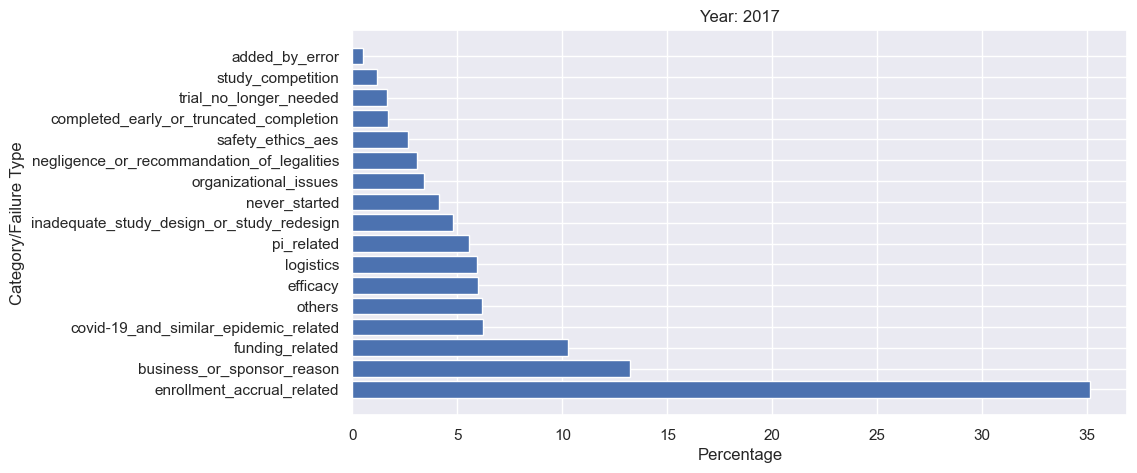

In [104]:
plot_year(2017)

In [105]:
%%jmd 
## 2018

## 2018

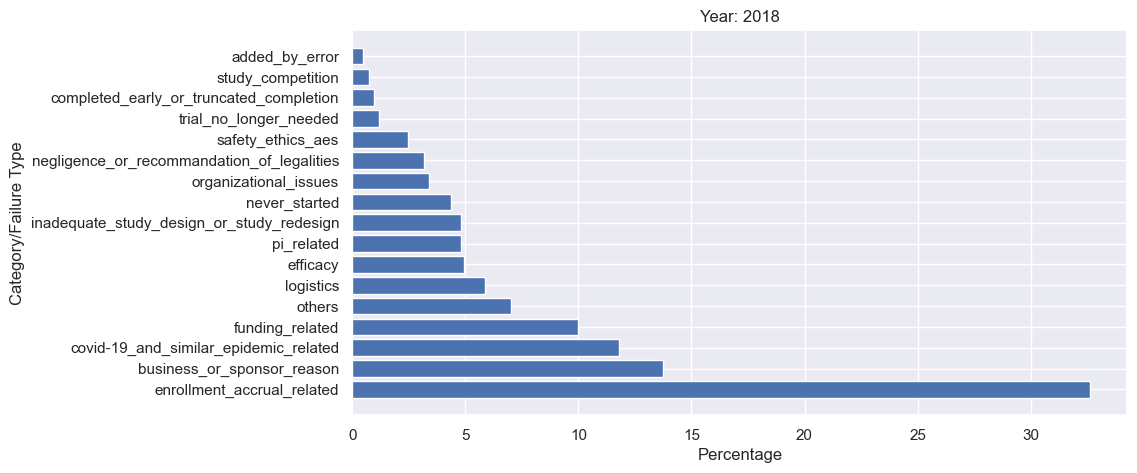

In [106]:
plot_year(2018)

In [107]:
%%jmd 
## 2019

## 2019

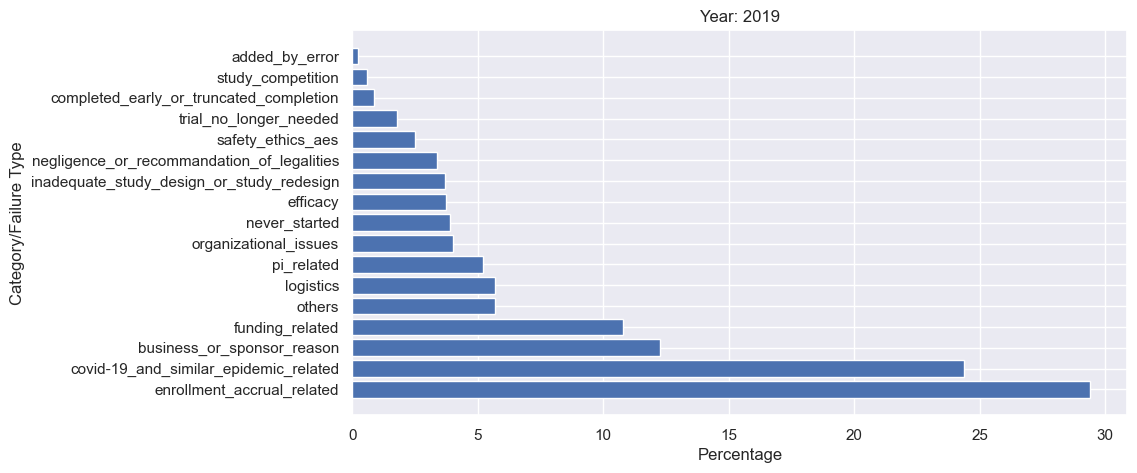

In [108]:
plot_year(2019)

In [109]:
%%jmd 
## 2020

## 2020

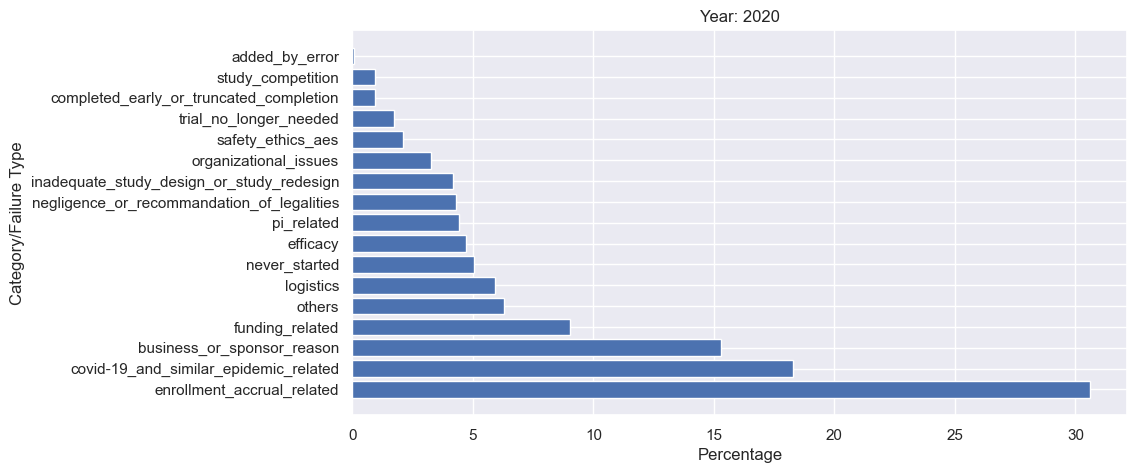

In [110]:
plot_year(2020)

In [111]:
%%jmd 
## 2021

## 2021

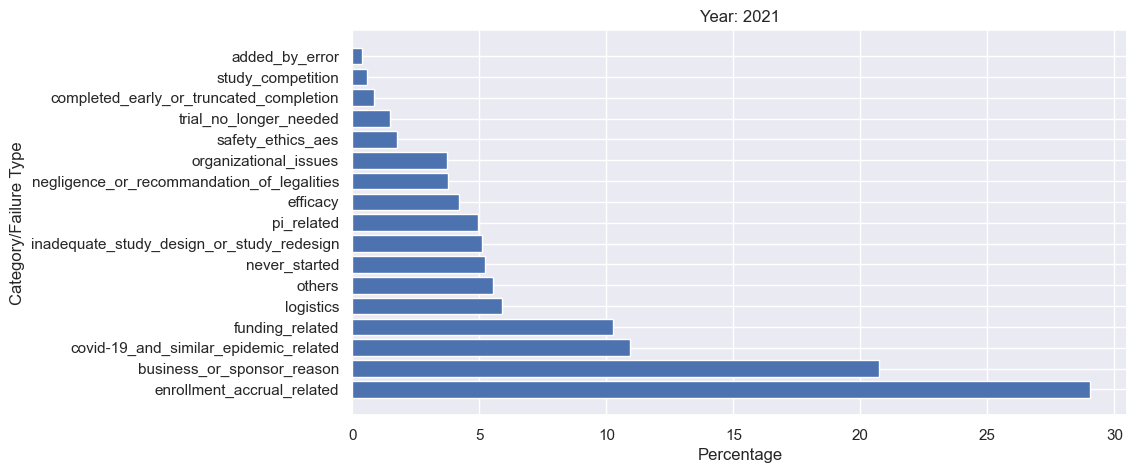

In [112]:
plot_year(2021)

In [113]:
%%jmd 
## 2022

## 2022

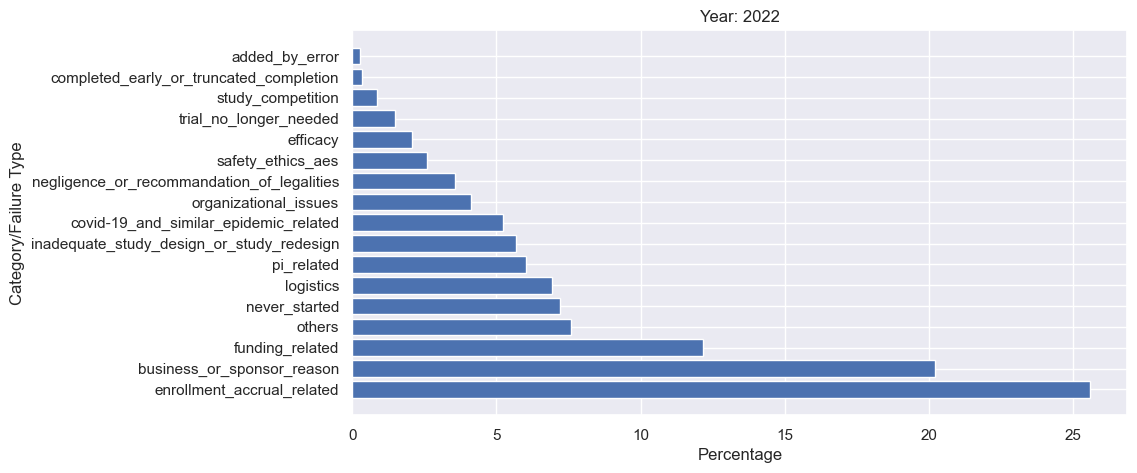

In [114]:
plot_year(2022)

In [115]:
%%jmd 
## 2023

## 2023

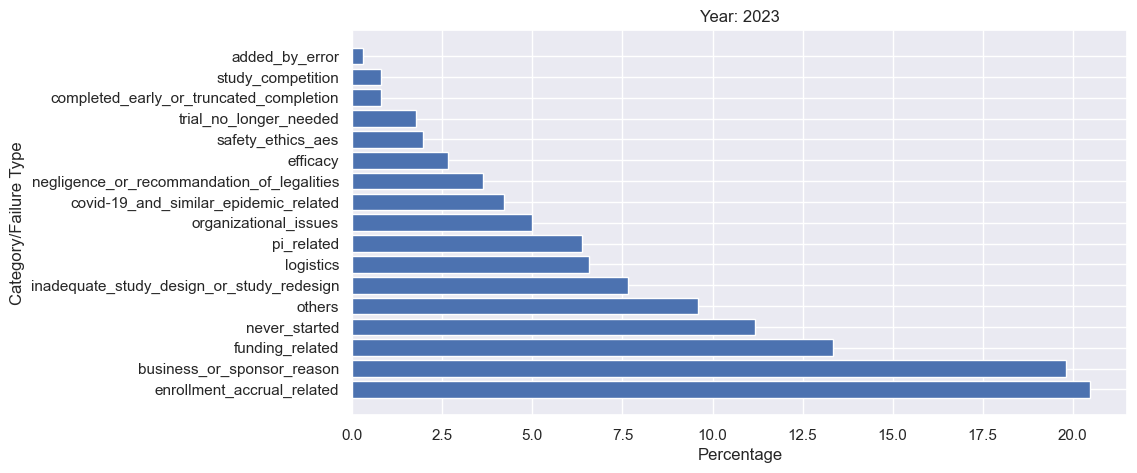

In [116]:
plot_year(2023)

In [117]:
%%jmd 
## 2024

## 2024

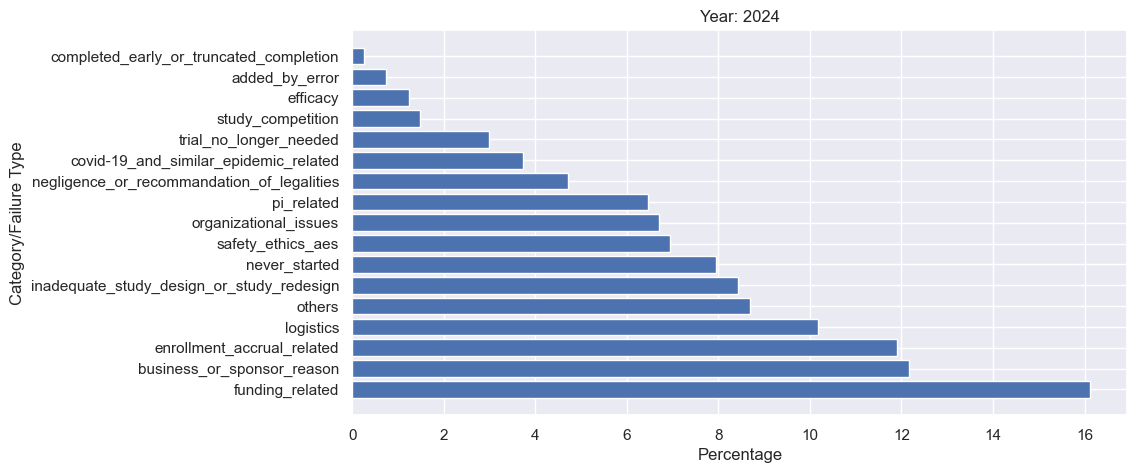

In [118]:
plot_year(2024)

In [119]:
%%capture
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming why_stop has a 'year' column
years = range(2017, 2024)

# Initialize a figure for the grid plot
fig, axs = plt.subplots(7, 1, figsize=(10, 25))  # Adjusted for 7 plots (2 rows, 4 columns)
axs = axs.flatten()  # Flatten to easily iterate over

for i, year in enumerate(years):
    # Filter the DataFrame for the current year
    why_stop_year = why_stop[why_stop['startDate'] == year]
    
    # Repeat the analysis for each year
    total_unique_nct_id_year = why_stop_year['nct_id'].nunique()
    
    # Category analysis
    category_counts_year = why_stop_year['category'].value_counts()
    category_percentage_year = (category_counts_year / total_unique_nct_id_year) * 100
    category_percentage_df_year = category_percentage_year.reset_index()
    category_percentage_df_year.columns = ['category', 'percentage']
    

    
    # Concatenate the two DataFrames for the year
    category_failure_df_year = pd.concat([category_percentage_df_year], ignore_index=True)
    
    # Plotting
    axs[i].barh(category_failure_df_year['category'], category_failure_df_year['percentage'])
    axs[i].set_title(f'Year: {year}')
    axs[i].set_xlabel('Percentage')
    axs[i].set_ylabel('Category/Failure Type')

# Adjust layout
plt.tight_layout()

# Hide any unused subplot (if not exactly 7 years)
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.show()

In [120]:
%%jmd 
# Overview of the distribution of Completed and Terminated Trials for the most common MeSH terms

# Overview of the distribution of Completed and Terminated Trials for the most common MeSH terms

In [121]:
# comparer proportion des diff overstatus pour ces main meshes
mesh_main_ancestor['term'].value_counts()
merged_main_mesh = ct.merge(mesh_main_ancestor, on='nct_id', how='left')
### 

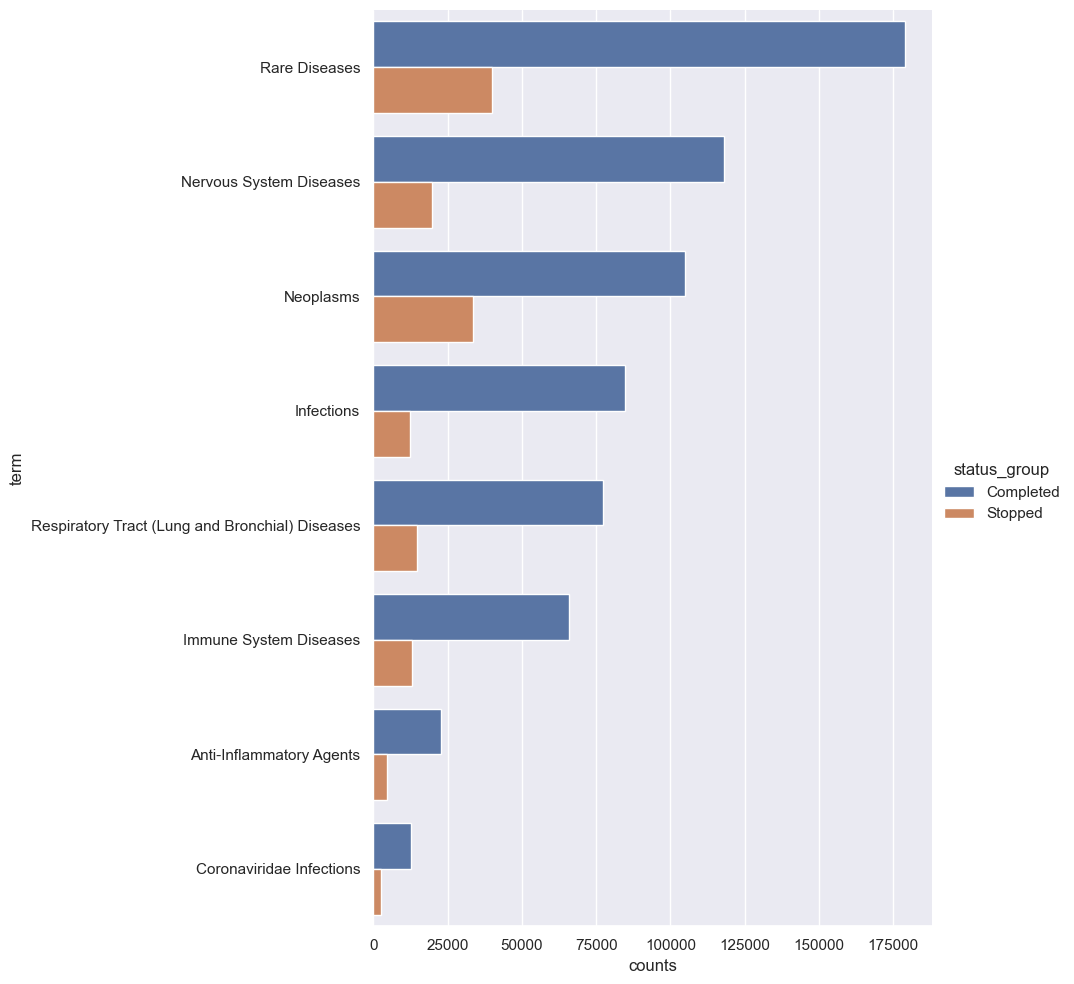

In [122]:

ongoing = ['RECRUITING','ACTIVE_NOT_RECRUITING','NOT_YET_RECRUITING',
           'ENROLLING_BY_INVITATION','AVAILABLE','APPROVED_FOR_MARKETING']
stopped = ['TERMINATED','WITHDRAWN','SUSPENDED','NO_LONGER_AVAILABLE','WITHDRAWN','TEMPORARILY_NOT_AVAILABLE','WITHHELD']
completed = ['COMPLETED']
# Add a new column 'status_group' to the dataframe
merged_main_mesh['status_group'] = merged_main_mesh['overallStatus'].apply(lambda x: 'Ongoing' if x in ongoing 
                                                                           else 'Stopped' if x in stopped 
                                                                           else 'Completed' if x in completed
                                                                           else 'Unknown')

# Group the data by 'term' and 'status_group'
grouped = merged_main_mesh.groupby(['term', 'status_group']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
# Create a horizontal bar chart
sns.catplot(x='counts', y='term', hue='status_group', data=grouped, kind='bar', height=10, aspect=1)
plt.show()


In [123]:
%%jmd 
## Distribution of Covid related Mesh terms

## Distribution of Covid related Mesh terms

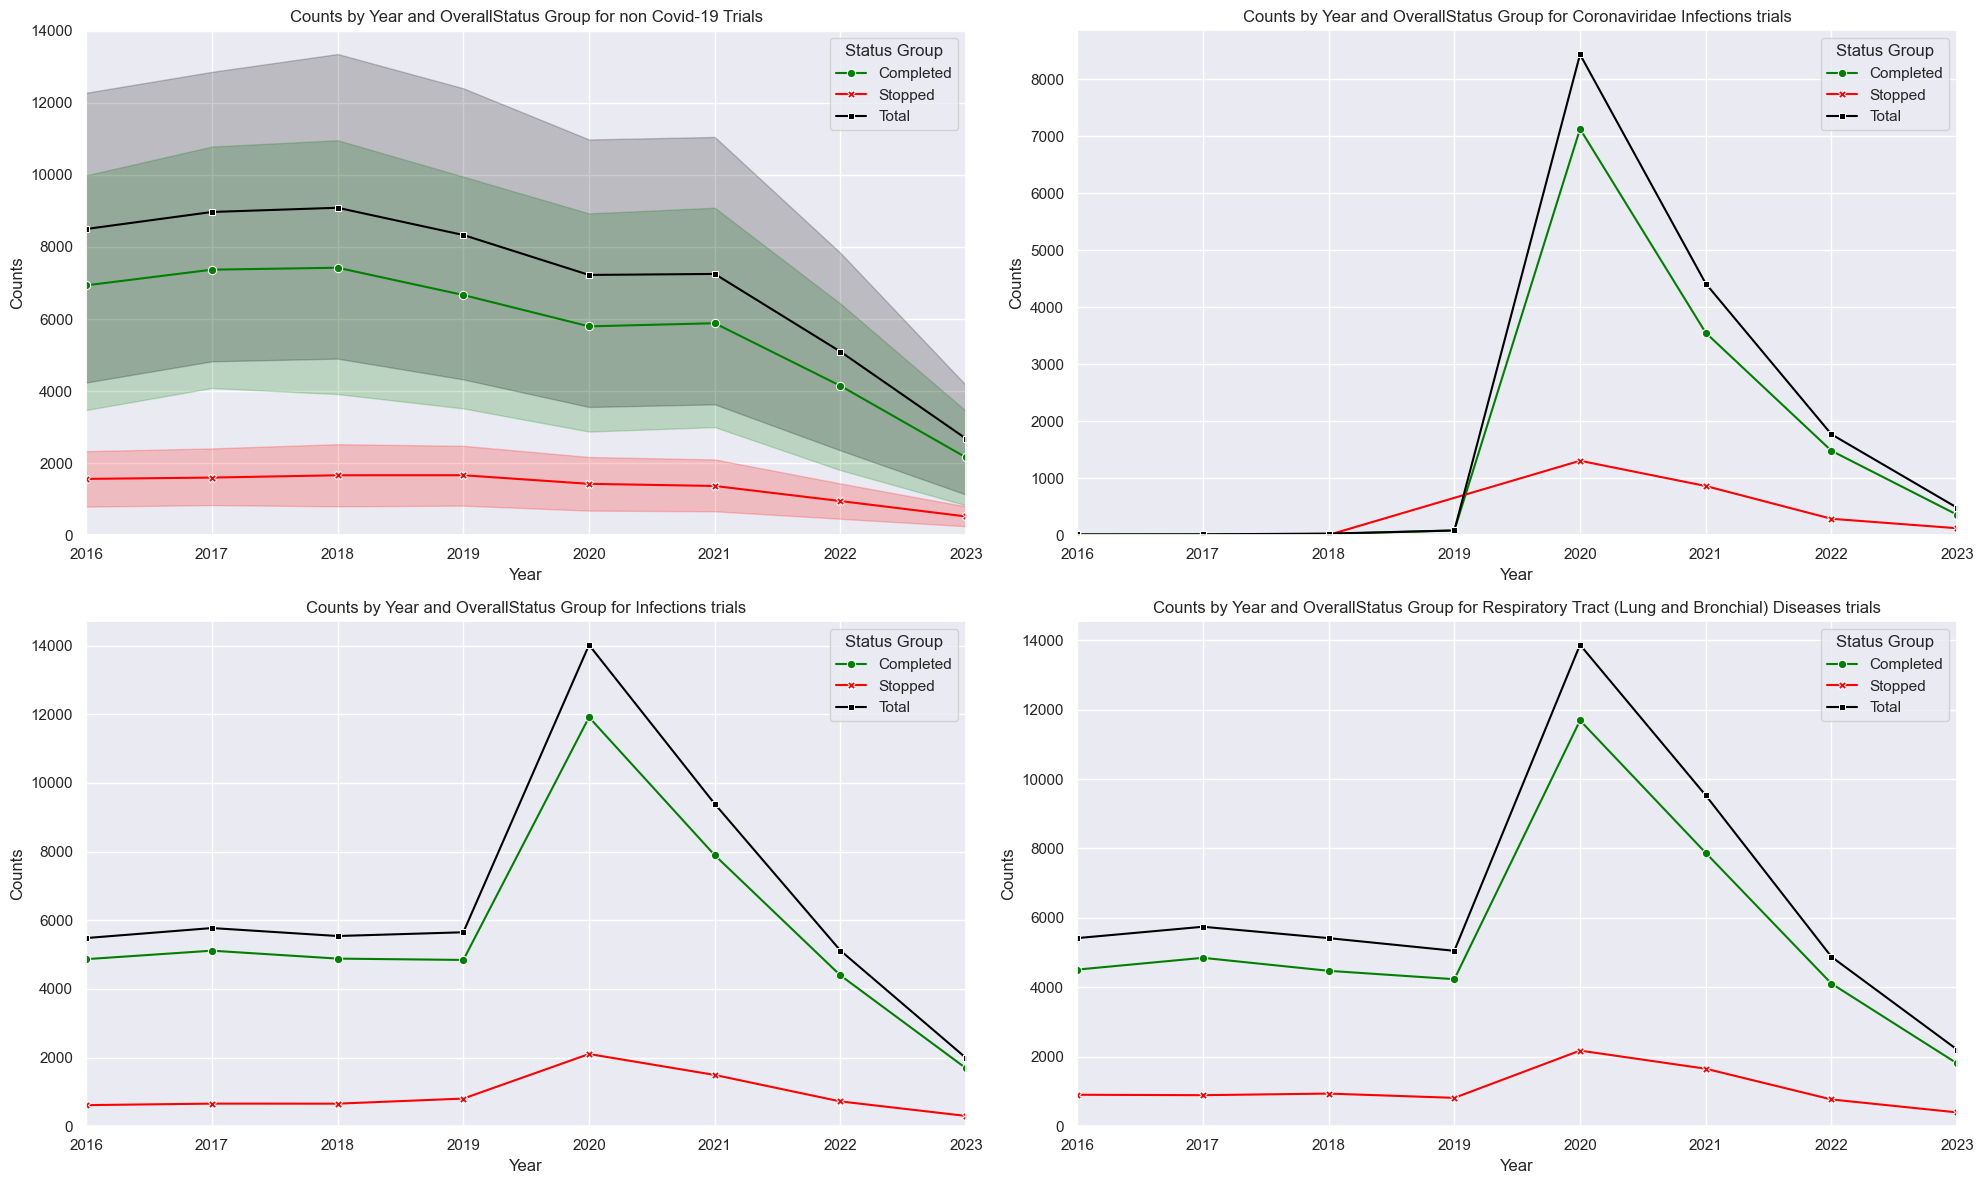

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Assuming 'merged_main_mesh' is your initial DataFrame and 'ongoing', 'stopped', 'completed' are defined

# Prepare a comprehensive DataFrame
all_years_data = []

years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

for year in years:
    merged_for_year = merged_main_mesh[merged_main_mesh['startDate'].astype(str).str.startswith(str(year))]
    # Exclude 'Ongoing' from status_group
    merged_for_year['status_group'] = merged_for_year['overallStatus'].apply(lambda x: 'Stopped' if x in stopped 
                                                                              else 'Completed' if x in completed
                                                                              else 'Unknown')
    grouped = merged_for_year.groupby(['term', 'status_group']).size().reset_index(name='counts')
    grouped['year'] = year  # Add the year column
    all_years_data.append(grouped)

# Concatenate all yearly data into a single DataFrame
all_years_df = pd.concat(all_years_data)

# Calculate total counts for each year and term, excluding 'Ongoing'
total_counts = all_years_df.groupby(['year', 'term'])['counts'].sum().reset_index()
total_counts['status_group'] = 'Total'

# Append total counts to the DataFrame
all_years_df = pd.concat([all_years_df, total_counts])

# Define the specific terms
terms_to_plot = [
    "all",  # Placeholder for all terms combined
    "Coronaviridae Infections",
    "Infections",
    "Respiratory Tract (Lung and Bronchial) Diseases"
]

# Define a color palette for the status groups
color_palette = {"Stopped": "red", "Completed": "green", "Unknown": "blue", "Total": "black"}

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()  # Flatten the array of axes for easy iterating

for index, term in enumerate(terms_to_plot):
    if term == "all":
        # Plot for all terms combined, excluding 'Ongoing'
        data_to_plot = all_years_df[~all_years_df['term'].isin(terms_to_plot)]
        title = 'Counts by Year and OverallStatus Group for non Covid-19 Trials'
    else:
        # Filter the DataFrame for the current term, excluding 'Ongoing'
        data_to_plot = all_years_df[all_years_df['term'] == term]
        title = f'Counts by Year and OverallStatus Group for {term} trials'
    
    # Plot on the respective subplot using the defined color palette
    sns.lineplot(ax=axs[index], data=data_to_plot, x='year', y='counts', hue='status_group', style='status_group', markers=True, dashes=False, palette=color_palette)
    axs[index].set_title(title)
    axs[index].set_xticks(years)  # Ensure all years are shown
    axs[index].set_ylabel('Counts')
    axs[index].set_xlabel('Year')
    axs[index].legend(title='Status Group')
    axs[index].set_xlim(2016, 2023)  # Set x-axis limits
    axs[index].set_ylim(0)  # Set y-axis limits

# Hide any unused subplots (if any)
for ax in axs[index + 1:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [125]:
%%jinja markdown
## Difference between periods

## Difference between periods

Average Stopped/Completed Ratio 2019-2022: 0.23932181597944419
Average Stopped/Completed Ratio for the rest: 0.21775728118082893


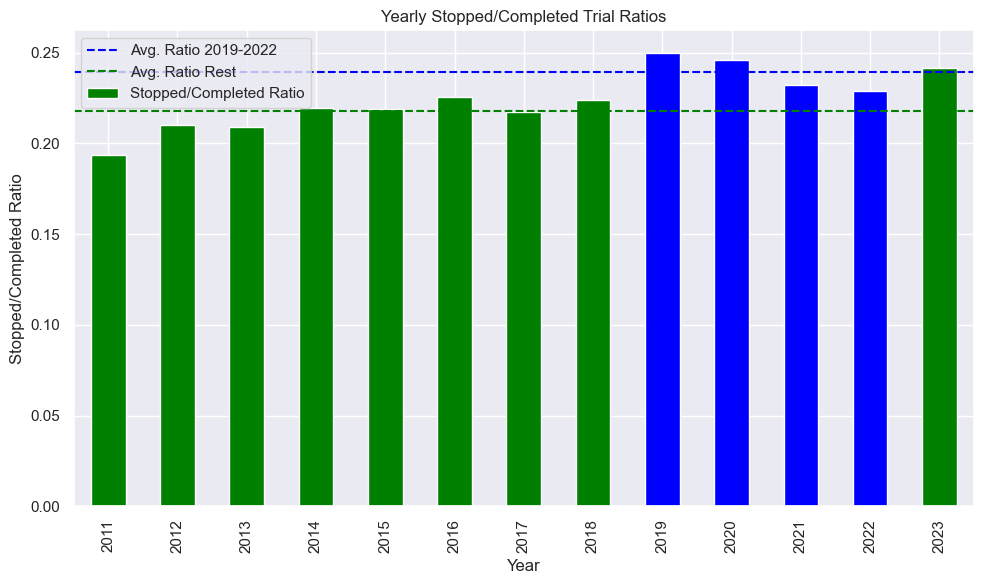

Chi-Square Test p-value: 3.609481571910223e-39
Odds Ratio: 0.8993380225894522


In [126]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Assuming all_years_df is your DataFrame

# Step 1: Calculate Ratios
# Filter DataFrame for 'Completed' and 'Stopped' status_group only
filtered_df = all_years_df[all_years_df['status_group'].isin(['Completed', 'Stopped'])]
# remove the covid trials
filtered_df = filtered_df[~filtered_df['term'].isin(["Coronaviridae Infections","Infections","Respiratory Tract (Lung and Bronchial) Diseases"])]

# Pivot to get a table where rows are years, columns are status_groups, and values are sums of counts
pivot_df = filtered_df.pivot_table(index='year', columns='status_group', values='counts', aggfunc='sum', fill_value=0)

# Calculate the ratio of Completed to Stopped for each year
pivot_df['Stopped/Completed Ratio'] = pivot_df['Stopped'] / pivot_df['Completed']

# Step 2: Group Years
# Define the periods
period1 = range(2019, 2023)  # 2018-2022
period2 = list(set(pivot_df.index) - set(period1))  # The rest of the years

# Calculate average ratio for each period
avg_ratio_period1 = pivot_df.loc[period1, 'Stopped/Completed Ratio'].mean()
avg_ratio_period2 = pivot_df.loc[period2, 'Stopped/Completed Ratio'].mean()

# Step 3: Compare Ratios
# Print the average ratios for comparison
print(f"Average Stopped/Completed Ratio 2019-2022: {avg_ratio_period1}")
print(f"Average Stopped/Completed Ratio for the rest: {avg_ratio_period2}")

# Optionally, plot the ratios for a visual comparison
plt.figure(figsize=(10, 6))
pivot_df['Stopped/Completed Ratio'].plot(kind='bar', color=['blue' if year in period1 else 'green' for year in pivot_df.index])
plt.title('Yearly Stopped/Completed Trial Ratios')
plt.xlabel('Year')
plt.ylabel('Stopped/Completed Ratio')
plt.axhline(avg_ratio_period1, color='blue', linestyle='--', label='Avg. Ratio 2019-2022')
plt.axhline(avg_ratio_period2, color='green', linestyle='--', label='Avg. Ratio Rest')
plt.legend()
plt.tight_layout()
plt.show()

# Step 4: Chi-Square Test and Odds Ratio
# Create a contingency table for the two periods
contingency_table = pivot_df.groupby(pivot_df.index.isin(period1)).sum()[['Completed', 'Stopped']]

# Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Test p-value: {p}")

# Calculating Odds Ratio
odds_period1 = contingency_table.loc[True, 'Completed'] / contingency_table.loc[True, 'Stopped']
odds_period2 = contingency_table.loc[False, 'Completed'] / contingency_table.loc[False, 'Stopped']
odds_ratio = odds_period1 / odds_period2
print(f"Odds Ratio: {odds_ratio}")

In [127]:
%%jinja markdown

Stopped/Completed Ratio Analysis:

The average Stopped/Completed Ratio for 2018-2022 is slightly higher than for the rest of the years. This suggests that, in the more recent period, there was a marginally higher proportion of trials that were stopped relative to those that were completed. However, the difference in ratios is small, indicating that the change might not be substantial.
Chi-Square Test:

The Chi-Square Test resulted in a very low p-value {{p}}, which indicates that there is a statistically significant difference in the distribution of 'Completed' and 'Stopped' status between the two periods. This statistical significance suggests that the observed differences in trial outcomes between the two periods are unlikely to have occurred by chance.
Odds Ratio:

The Odds Ratio of {{odds_ratio|round(3)}} indicates that the odds of trials being completed versus stopped in the first period (2018-2022) are slightly lower than in the rest of the years. This suggests a small decrease in the likelihood of trials being completed in the first period compared to the rest, although the effect size is relatively modest.
Overall Conclusion:

There is a statistically significant difference in the overall status of trials between the two periods, with a slight decrease in the likelihood of trials being completed in the more recent period (2018-2022) compared to the rest of the years. However, the practical significance of this finding, as indicated by the small difference in Stopped/Completed Ratios and the modest Odds Ratio, may not be very large. This analysis highlights the importance of considering both statistical significance and effect size when interpreting results.


Stopped/Completed Ratio Analysis:

The average Stopped/Completed Ratio for 2018-2022 is slightly higher than for the rest of the years. This suggests that, in the more recent period, there was a marginally higher proportion of trials that were stopped relative to those that were completed. However, the difference in ratios is small, indicating that the change might not be substantial.
Chi-Square Test:

The Chi-Square Test resulted in a very low p-value 3.609481571910223e-39, which indicates that there is a statistically significant difference in the distribution of 'Completed' and 'Stopped' status between the two periods. This statistical significance suggests that the observed differences in trial outcomes between the two periods are unlikely to have occurred by chance.
Odds Ratio:

The Odds Ratio of 0.899 indicates that the odds of trials being completed versus stopped in the first period (2018-2022) are slightly lower than in the rest of the years. This suggests a small decrease in the likelihood of trials being completed in the first period compared to the rest, although the effect size is relatively modest.
Overall Conclusion:

There is a statistically significant difference in the overall status of trials between the two periods, with a slight decrease in the likelihood of trials being completed in the more recent period (2018-2022) compared to the rest of the years. However, the practical significance of this finding, as indicated by the small difference in Stopped/Completed Ratios and the modest Odds Ratio, may not be very large. This analysis highlights the importance of considering both statistical significance and effect size when interpreting results.

In [128]:
%%jinja markdown
# Distribution of termination categories by Mesh term

# Distribution of termination categories by Mesh term

In [129]:
%%capture
import matplotlib.pyplot as plt


# Add a new column 'status_group' to the dataframe
merged_main_mesh['status_group'] = merged_main_mesh['overallStatus'].apply(lambda x: 'Ongoing' if x in ongoing 
                                                                           else 'Stopped' if x in stopped 
                                                                           else 'Completed' if x in completed
                                                                           else 'Unknown')
# Get the different 'term' values
terms = merged_main_mesh['term'].unique()

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 15))

# Create a pie chart for each 'term' value
for i, term in enumerate(terms):
    data = merged_main_mesh[merged_main_mesh['term'] == term]['status_group'].value_counts()
    labels = [f'{label} (Total: {count})' for label, count in zip(data.index, data)]
    axs[i//3, i%3].pie(data, labels=labels, autopct='%1.1f%%')
    total = len(merged_main_mesh[merged_main_mesh['term'] == term])
    axs[i//3, i%3].set_title(f'{term} (Total: {total})')

# Remove the unused subplots if the number of 'term' values is not a multiple of 3
for j in range(i+1, 9):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

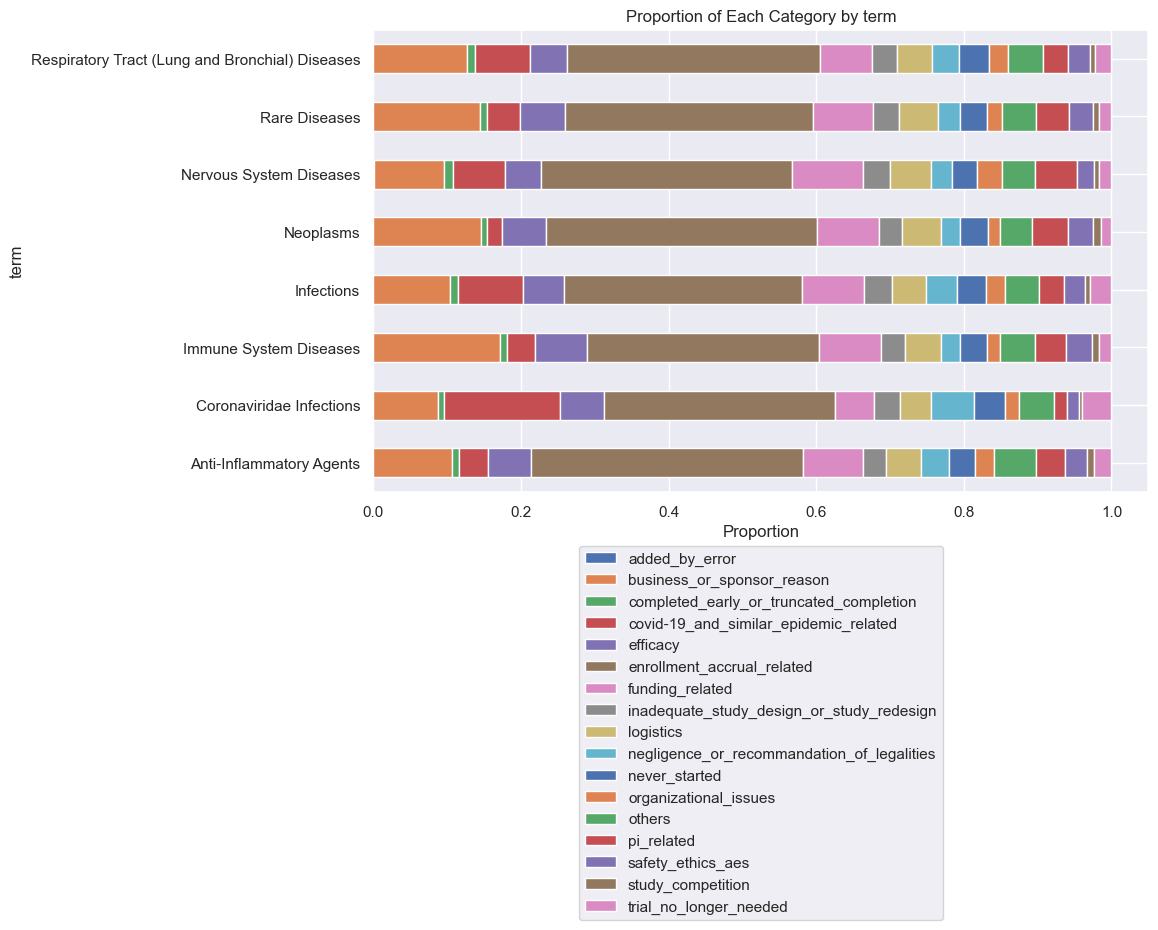

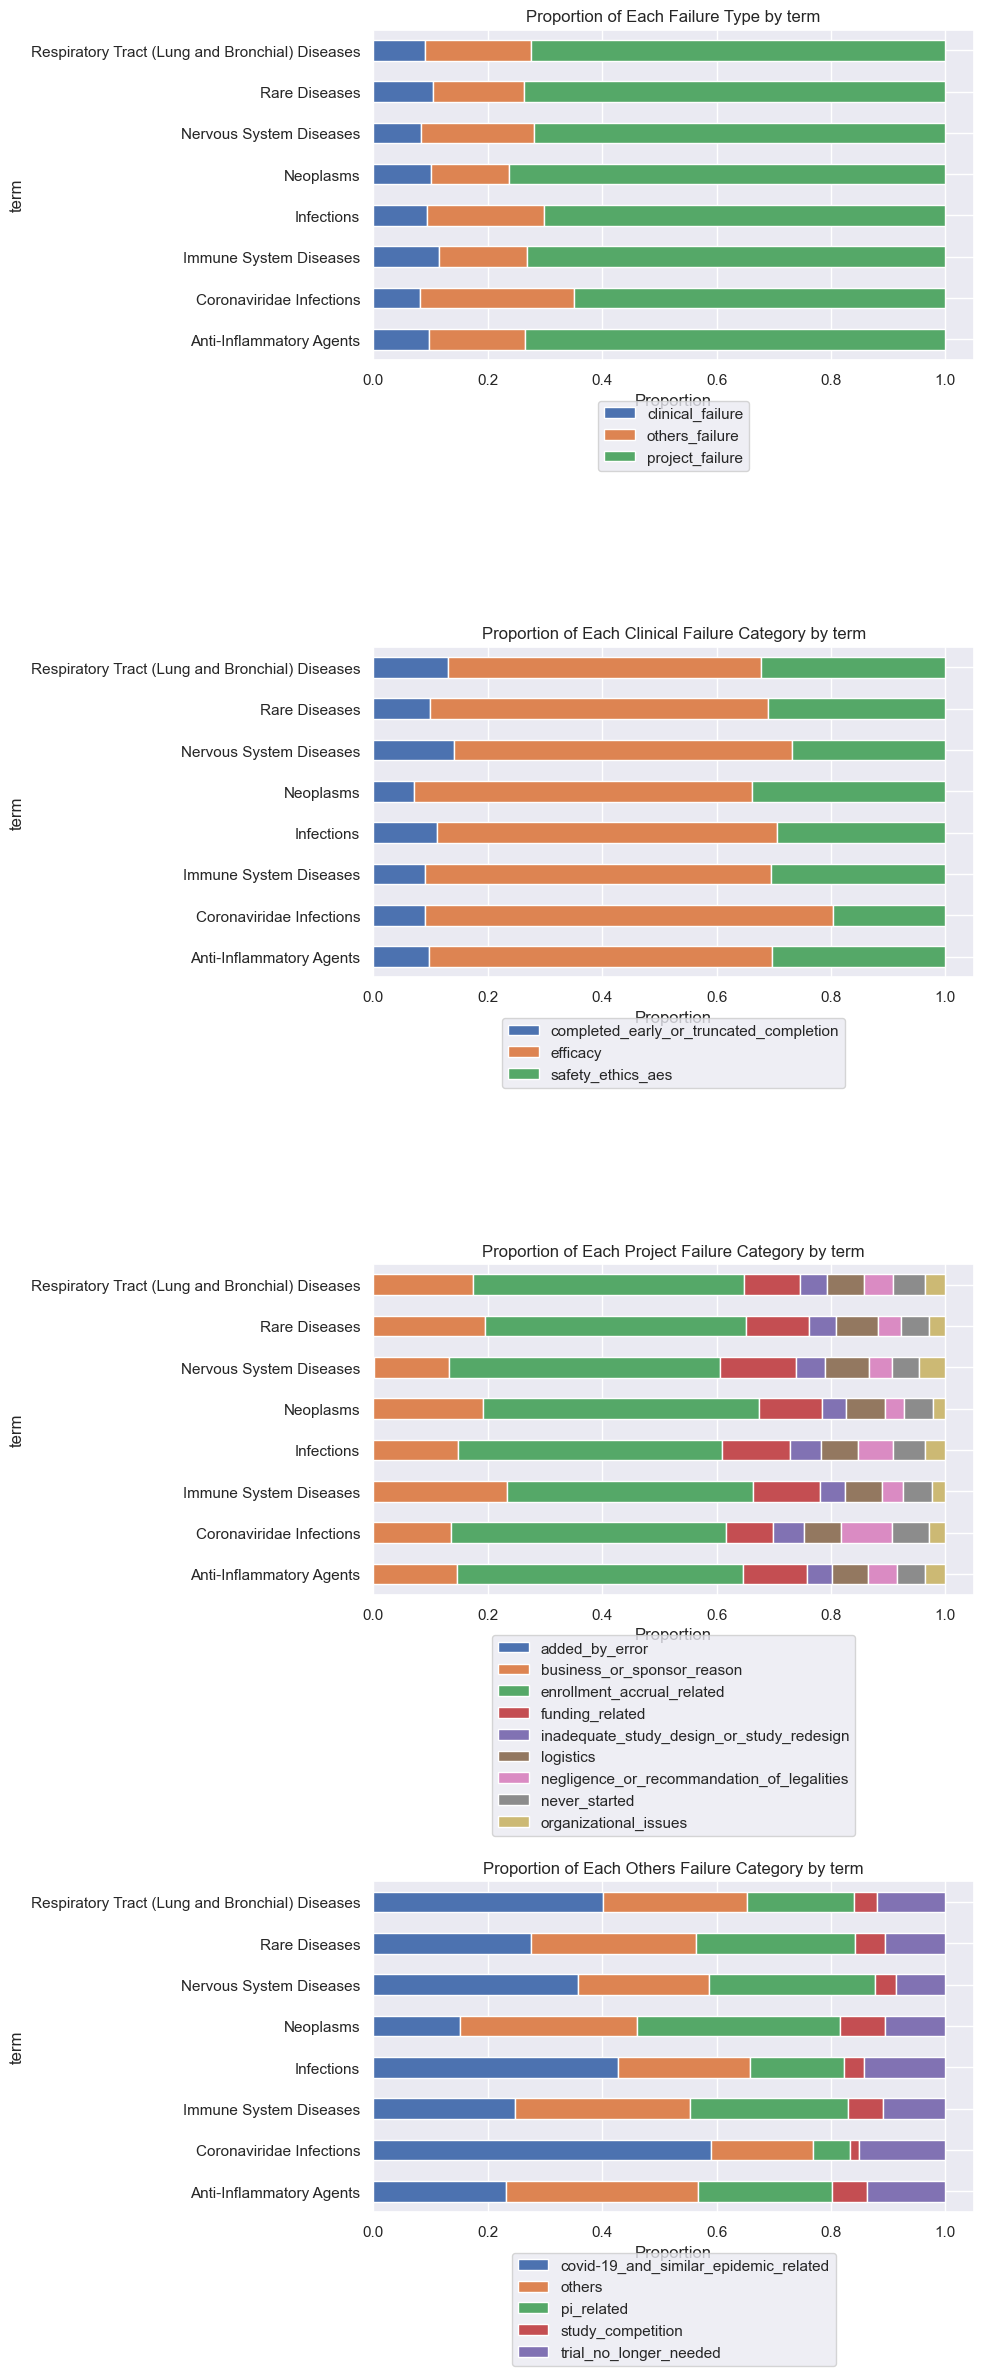

In [130]:
## type d'arret par category
why_stop
mesh_main_ancestor
whystop_by_mesh = why_stop.merge(mesh_main_ancestor, on='nct_id', how='left')


# Create a horizontal stacked bar plot for category
grouped_data_category = whystop_by_mesh.groupby(['term', 'category']).size().unstack()
grouped_data_category = grouped_data_category.div(grouped_data_category.sum(axis=1), axis=0)
grouped_data_category.plot(kind='barh', stacked=True, figsize=(10, 6))
plt.xlabel('Proportion')
plt.ylabel('term')
plt.title('Proportion of Each Category by term')
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center')
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(10, 24))  # Change the number of subplots to 4

# Create a horizontal stacked bar plot for failure_type
grouped_data_failure_type = whystop_by_mesh.groupby(['term', 'failure_type']).size().unstack()
grouped_data_failure_type = grouped_data_failure_type.div(grouped_data_failure_type.sum(axis=1), axis=0)
grouped_data_failure_type.plot(kind='barh', stacked=True, ax=axs[0])  # Change the index to 0
axs[0].set_xlabel('Proportion')  # Change the index to 0
axs[0].set_ylabel('term')  # Change the index to 0
axs[0].set_title('Proportion of Each Failure Type by term')  # Change the index to 0
axs[0].legend(bbox_to_anchor=(0.5, -0.1), loc='upper center')  # Change the index to 0

# Create a horizontal stacked bar plot for each failure type category
failure_types = ['clinical_failure', 'project_failure', 'others_failure']
titles = ['Clinical Failure', 'Project Failure', 'Others Failure']

for i, failure_type in enumerate(failure_types):
    whystop_by_mesh1 = whystop_by_mesh[whystop_by_mesh['failure_type'] == failure_type]
    grouped_data_category = whystop_by_mesh1.groupby(['term', 'category']).size().unstack()
    grouped_data_category = grouped_data_category.div(grouped_data_category.sum(axis=1), axis=0)
    grouped_data_category.plot(kind='barh', stacked=True, ax=axs[i+1])  # Change the index to i+1
    axs[i+1].set_xlabel('Proportion')  # Change the index to i+1
    axs[i+1].set_ylabel('term')  # Change the index to i+1
    axs[i+1].set_title(f'Proportion of Each {titles[i]} Category by term')  # Change the index to i+1
    axs[i+1].legend(bbox_to_anchor=(0.5, -0.1), loc='upper center')  # Change the index to i+1

plt.tight_layout()
plt.show()

